# Network models

These examples provides an overview of the `twpasolver` library's basic capabilities, focusing on the implementation of various circuit components and their compositions. The classes involved include `Models`, `TwoPortCell`, and `ABCDArrays`, which offer functionalities to handle one-port and two-port circuit components. The core functionalities are housed within `twpasolver.twoport` and `twpasolver.models`. 

### Overview

`twpasolver` provides simple functionalities to handle one-port and two-port circuit components. Each component is implemented as a class that defines how its ABCD matrix is computed as a function of an input frequency array. These models, which are derived from `twpasolver.twoport.TwoPortModel`, can be found in the ```twpasolver.models``` subpackage.
The response of the circuit element is accessed by calling one of the ```get``` methods of the model class.

* `get_abcd(freq_array)` returns an instance of `twpasolver.ABCDArray`. It is a specialized subclass of `numpy.array` which is used to represent arrays of 2x2 matrices and includes efficient matrix multiplication operations. This class is the fundamental building block for constructing the response of concatenated circuit elements.
* `get_cell(freq_array)` returns a `TwoPortCell` class, which contains an `ABCDArray`, a frequencies array, and additional functions to convert responses to S-parameters and `scikit-rf.Network` objects.
* `get_network(freq_array)` directly returns a ```scikit-rf.Network``` with the computed response.

Some other features common to all models implemented in `twpasolver` are:

* Repetition of $N$ consecutive instances of the circuit through the `N` attribute.
* Dumping and loading to/from json files and attribute validation, implemented through `pydantic`.

### Example: Capacitor

Let's start with a simple example of analyzing a capacitor. We will create a capacitor model, compute its response over a frequency range, and plot the S-parameters.

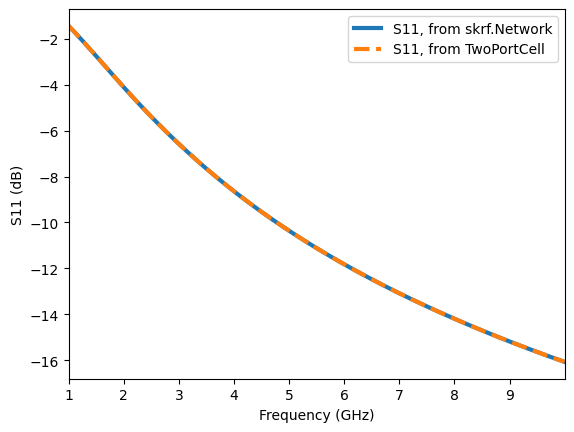

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from twpasolver.mathutils import to_dB
from twpasolver.models import Capacitance

# Define frequency range
freqs = np.arange(1e9, 10e9, 1e6)

# Create capacitor
C_val = 1e-12  # 1 pF
C = Capacitance(C=C_val)

# Get network response and plot S11
net = C.get_network(freqs)
net.s11.plot_s_db(label="S11, from skrf.Network", lw=3)

# Get cell response and plot S11
cell = C.get_cell(freqs)
plt.plot(cell.freqs, to_dB(cell.s.S11), label="S11, from TwoPortCell", ls="--", lw=3)
plt.ylabel("S11 (dB)")
plt.legend()
plt.show()

Dump the model to a json file and recover it.

In [2]:
C.dump_to_file("Capacitor.json")
C_recovered = Capacitance.from_file("Capacitor.json")
print(C == C_recovered)
C.model_dump()

True


{'Z0_ref': 50.0,
 'N': 1,
 'twoport_parallel': False,
 'name': 'Capacitance',
 'C': 1e-12}

### ModelArrays

`OnePortModel` and `TwoPortModel` instances can be assembled into arrays, and the overall response be retrieved automatically. This can be done wither by instancing the arrays directly or by using the `twpasolver.models.compose` function. In this way it is possible to connect multiple components in series or parallel to form more complex networks.
The `compose` function returns either:

* A ```OnePortArray``` if all the elements are ```OnePortModel```s and have the same series/parallel configuration when inserted in a two-port network, which is specified by the ```twoport_parallel``` attribute present in all ```OnePortModel``` derived classes. Since one-port elements are specified entirely by their impedance response, they are specialized to allow connecting them in parallel or in series into another one port network, which simplifies calculations and makes it possible to create more complex elements to insert into a two-port circuit. 
* A ```TwoPortArray``` otherwise. The composition of two-port circuits is based entirely on multiplying their abcd matrices.

Some functionalities common to both kinds of model arrays are:

* Basic list operations, such as appending and indexing/slicing.
* Compatibility with nested arrays.
* Correct serialization of nested structures to json.

### Example: LC Resonator and resonators array

Now let's create an LC resonator by combining an inductor and a capacitor, which returns a `OnePortArray`, and plotting its frequency response.

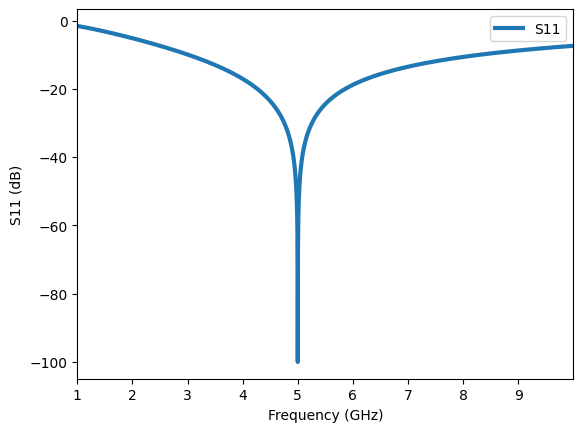

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from twpasolver.mathutils import to_dB
from twpasolver.models import Capacitance, Inductance, Resistance, compose

# Define frequency range
freqs = np.arange(1e9, 10e9, 2e6)

# Resonance frequency and inductance value
f_res = 5e9
L_val = 1e-9
R_val = 1e-3

# Create series LC resonator
L = Inductance(L=L_val)
C = Capacitance(C=1 / ((f_res * 2 * np.pi) ** 2 * L_val))
R = Resistance(R=R_val)
LCres = compose(L, C, R)

net = LCres.get_network(freqs)
net.s11.plot_s_db(lw=3)
plt.ylabel("S11 (dB)")
plt.show()

Finally, we create an array of LC resonators with different resonance frequencies inserted in parallel in a two-port network and observe their combined response.

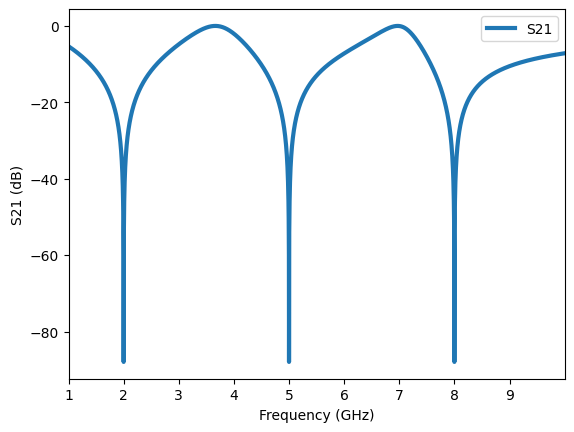

In [4]:
from twpasolver.models import TwoPortArray

# Create array of LC resonators with different resonance frequencies
LCarray = TwoPortArray()
for f_res in np.linspace(2e9, 8e9, 3):
    C = Capacitance(C=1 / ((f_res * 2 * np.pi) ** 2 * L_val))
    LC = compose(L, C, R)
    LC.twoport_parallel = True
    LCarray.append(LC)

# Get network response and plot S21
net = LCarray.get_network(freqs)
net.s21.plot_s_db(lw=3, label="S21")
plt.ylabel("S21 (dB)")
plt.show()